In [3]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

In [4]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
            
Klist0 = [ FKernel(Log, ['q'], 1)]
Klist = []
Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['emis', 'pl', 'rl', 'ri','ts'])]


fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)

D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
D2[0]['t'].fit(fit_genator[0][0][:,:,9])
D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)
del(normal_generator)


##### Full Preprocessing :
FP = Klist0 + D + Klist + D2  + D3 + V 

##### b_size
batch_size= 64


train_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)
validation_generator = Up_and_Down_Generator(folder='Data', batch_size=batch_size, train=False, preprocess_x=FP, shuffle=1, custom_b_p_e= 500)
cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [4]:
# Set Cold generator
cold_generator.List_of_dir=['Data2/20190401_0400z_antartica/']
cold_generator._div = 5
cold_generator.idx_file = [4,9,14,19,23]
# Set "normal generator"
train_generator.idx_file = np.arange(25)
j=25
for i in range(25):
    if(i%5==4):
        if(i<j):
            j=j-1
            if(j%5==4):
                j-=1     
            a,b = train_generator.idx_file[i], train_generator.idx_file[j]
            train_generator.idx_file[j] = a
            train_generator.idx_file[i] = b
train_generator._div = 20            
train_generator.idx_file = train_generator.idx_file[:20]
print(train_generator.idx_file)
print(cold_generator.idx_file)

[ 0  1  2  3 23  5  6  7  8 22 10 11 12 13 21 15 16 17 18 20]
[4, 9, 14, 19, 23]


array([[1.        , 0.05515239],
       [0.05515239, 1.        ]])

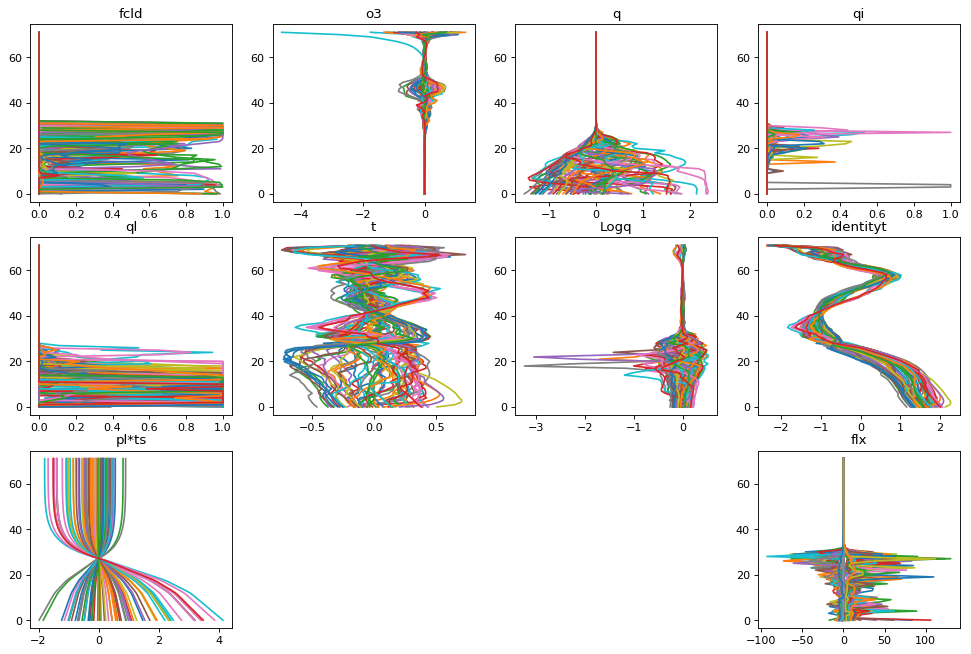

In [5]:
x,y=cold_generator[500]
Plot_Batch(x,y, header_x)
np.corrcoef(x[:,:,4].flatten(),x[:,:,3].flatten())

In [13]:
from keras import Sequential
from keras.layers import TimeDistributed, Dense
model = Sequential()
#model.add(TimeDistributed(Dense(8, use_bias=False), input_shape=(10, 16)))
model.add(Dense(8, use_bias=False, input_shape=(10,16)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10, 8)             128       
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [1]:
from architectures import AE
from CST import CST
o_channel = 3
in_channel=11
list_of_filters_ae = [ [50], [50, 50, 25, 25, 100, 100], [270], [50,50, 100, 100, 200,200],[300, o_channel]]
list_of_kernel_ae = [ [3],  [2, 2, 2, 2, 2, 2], [], [2, 2, 2, 2, 2, 2], [5, 2]]
list_of_activations_ae = [ ['elu'], ['elu', 'elu', 'elu','elu', 'elu', 'elu'],
                          ['sigmoid'],['elu','elu','elu','elu','elu','elu'], ['elu','linear']]
params_ae = [0.1]

M0 = AE(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)
M0.summary()

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(?, ?)
(?, 2430)


/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Convs_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Convs_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_102", strides=2)`
  Convs_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Convs_l1[-1]))


IndexError: list index out of range

In [6]:
#### 20190525000236U
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime


inter_channel=100
ups=5
pooling=3
params_bd = [0.1]
params_u = [0.1]

list_of_filters_bdc=[[64, 100, 32], [32, 20,10], [inter_channel]]
list_of_kernel_bdc=[[12, 5, 5], [10, 5, 3], [5,3]]
list_of_activations_bdc = [['elu','elu','elu'],['elu','elu','elu'],['relu']]

list_of_filters_unet = [[50, 25, 100], [270], [50, 100, 200],[300, o_channel]]
list_of_kernel_unet = [[10, 5, 3], [], [6, 10, 20], [5, 2]]
list_of_activations_unet = [ ['elu', 'elu', 'elu'],['sigmoid'],['elu','elu','elu'], ['elu','linear']]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_bd_cas = Bidir_Casual_Conv(list_of_kernel_bdc, list_of_filters_bdc, list_of_activations_bdc, \
                             params_bd, in_channel, lev=CST.lev(CST))
# unet
M_unet = Unet_Act_Simple(list_of_kernel_unet, list_of_filters_unet, list_of_activations_unet,\
                         params_u, Div=3, lev=CST.lev(CST), in_channel=inter_channel, o_channel=o_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_bd_cas); M.layers[-1].name = 'U_bd_cas'
#M.add(Dropout(rate=0.1, noise_shape=(batch_size, 1, inter_channel), seed=seed ))
M.add(M_unet); M.layers[-1].name = 'Unet'

if(False):
    for i,l in enumerate(M.layers):
        if i!=2 :
            l.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:76: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:79: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_1", strides=2)`
  stride=2, name=Name('AVG', i+1))(ACT_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:79: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_2", strides=2)`
  stride=2, name=Name('AVG', i+1))(ACT_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:79: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_3", strides=2)`
  stride=2,

In [7]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "U"

LH = LossHistory(frequency=train_generator.batch_per_file)
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=total_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss, dfdts_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 9)             0         
_________________________________________________________________
U_bd_cas (Model)             (None, 72, 100)           82950     
_________________________________________________________________
Unet (Model)                 (None, 72, 3)             3341155   
Total params: 3,424,105
Trainable params: 3,424,105
Non-trainable params: 0
_________________________________________________________________


In [7]:
#M.load_weights(os.path.join('TrainedModels/20190529085758U'))

In [8]:
#train_generator.max_b = 20*train_generator.batch_per_file

In [25]:
history = M.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=5,
                               verbose=1)

Epoch 1/5
77760/77760 [==============================] - 2298s 30ms/step - loss: 3255.5280 - flxd_loss: 23.3544 - flxu_loss: 11.7703 - dfdts_loss: 2892.7677 - val_loss: 56.2263 - val_flxd_loss: 22.5601 - val_flxu_loss: 13.8601 - val_dfdts_loss: 15.5127
Epoch 2/5
77760/77760 [==============================] - 2334s 30ms/step - loss: 26398669634.1120 - flxd_loss: 7471154.8970 - flxu_loss: 8867384.8501 - dfdts_loss: 26382332072.9934 - val_loss: 13284.8125 - val_flxd_loss: 194.8516 - val_flxu_loss: 97.7051 - val_dfdts_loss: 2075.3558
Epoch 3/5
  794/77760 [..............................] - ETA: 38:55 - loss: 7036.5808 - flxd_loss: 121.3670 - flxu_loss: 60.7578 - dfdts_loss: 1374.6136

KeyboardInterrupt: 

In [24]:
#K.set_value(Adam.lr, 0.001)
#train_generator.batch_size = 32
K.get_value(Adam.iterations)

116640

In [ ]:
# IMPORTANT MODEL LOG SAVER
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        for i, model in enumerate(M.layers):
            model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Bdc')
        print('list_of_filters_bdc = ', list_of_filters_bdc)
        print('list_of_kernel_bdc = ', list_of_kernel_bdc)
        print('list_of_activation_bdc = ', list_of_activations_bdc)
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        print('list_of_activation_unet = ', list_of_activations_unet)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

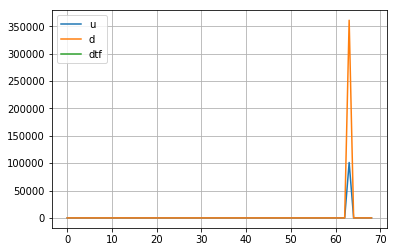

In [58]:
flxu_loss_h = LH.losses['flxu_loss'][1:70].copy()
flxd_loss_h = LH.losses['flxd_loss'][1:70].copy()
dfdts_loss_h = LH.losses['dfdts_loss'][1:70].copy()*0
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
ax.plot(flxu_loss_h)
ax.plot(dfdts_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['u','d', 'dtf']);

In [50]:
np.argmax(dfdts_loss_h)
np.argmax(dfdts_loss_h[20:80])

44

In [53]:
44+20;
13-1+20+20

52

In [39]:
len(LH.losses['flxu_loss'])

82

In [40]:
# Losses are on 13 


4.1

In [10]:
#M.load_weights('TrainedModels/20190528180258U')
M.load_weights('TrainedModels/20190528184629U')

In [15]:
M.get_weights()[-1].shape

(2, 300, 3)

In [ ]:
(5, 200, 300)

In [11]:
print(x.shape)
print(header_x)

(64, 72, 9)
['emis', 'fcld', 'o3', 'q', 'qi', 'ql', 't', 'ts', 'ts*pl']


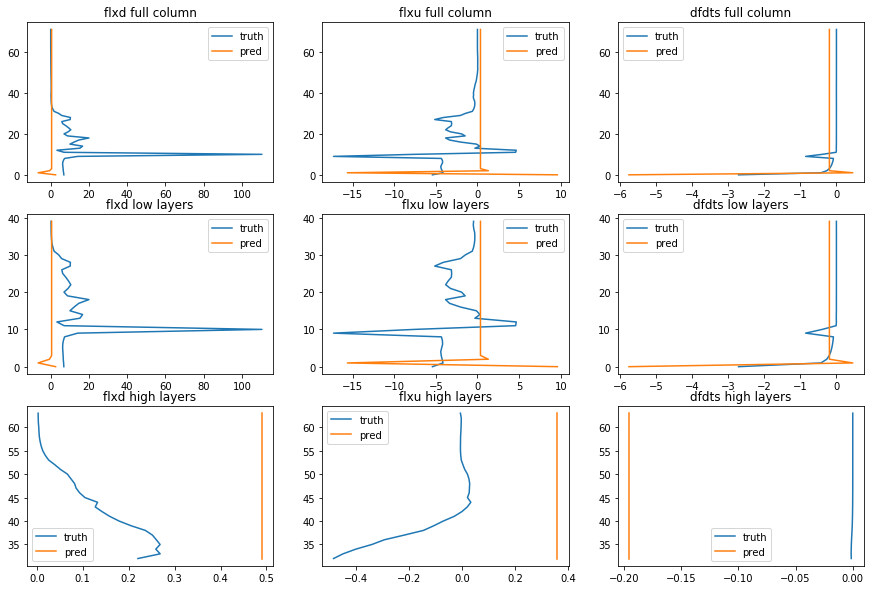

<Figure size 1080x576 with 0 Axes>

In [48]:
from utils import Plot_triple_diff_separated, F_and_plots
x,y = validation_generator[validation_generator.batch_per_file*3+1]
#x*=0
y0 = M.predict(x)
Plot_triple_diff_separated(F_and_plots(shape=(3,3)), y, y0, header_y, 32)

In [21]:
train_generator.batch_size = 64
#len(validation_generator)
#l=[]
#j=0
#for x,y in train_generator:
#    print(j)
#    l.append(K.get_value(total_loss(y, M.predict(x))))
#print(l)

In [18]:
for i in range(len(l)):
    print(np.mean(l[i]))

44.74688


In [60]:
# CHECKING IMPACT OF LOWER LAYER
validation_generator.batch_size =512
x,y = validation_generator[0]

#o =M.layers[2].get_layer('dense_1').output
i = M_bd_cas.get_input_at(0)
#i  = M.layers[1].get_input_at(1)
o = M_bd_cas.get_output_at(0)
First_model = K.function([i],[o])

i0 = M_Up.get_input_at(0)
o0 = M_Up.get_output_at(0)
#
i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)
#
o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('Conv2_3').get_output_at(0)

Up_model = K.function( [i0],[o0])
Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])

#img = Dense_layer(First_model([x]))[0]

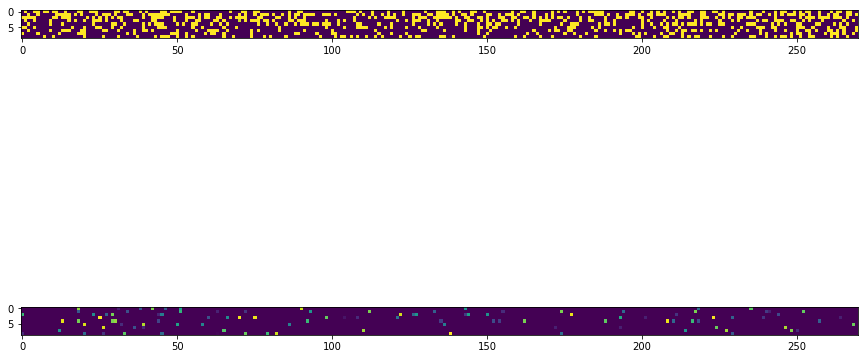

In [63]:
img = Dense_layer(First_model(Up_model([x])))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(211)
ax.imshow(img[1])
ax = f.add_subplot(212)
ax.imshow(np.std(img, axis=0))
#ax.imshow(np.mean(img,axis=0))

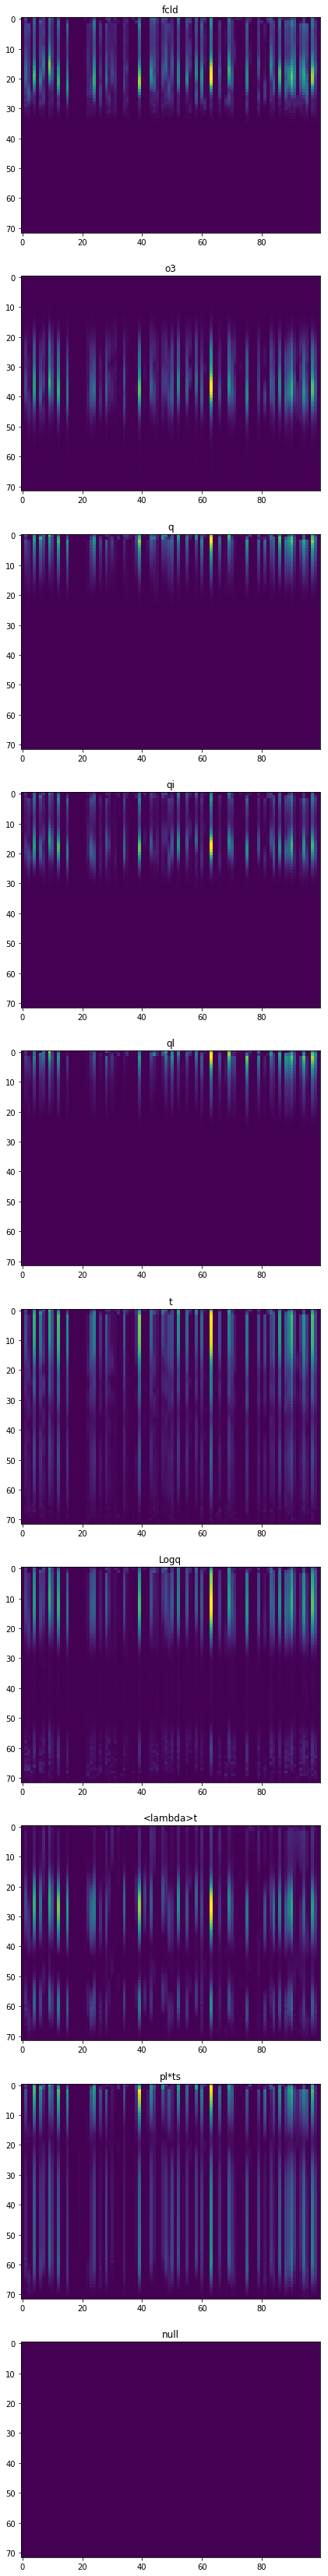

In [87]:
from utils import F_and_plots
x, y = validation_generator[400]
#X=[x.copy()]
X=[]
for i in range(len(header_x)):
    X.append(x.copy())
    X[i] *= 0
    X[i][:,:,i] = x[:,:,i]
X.append(x.copy()*0)

#    if(i==3):
#        X[i][:,:41, 3]=0

layer_output = [ First_model(Up_model([xi])) for xi in X ]
F = F_and_plots(shape=(len(header_x)+1,1), figsize=(20, 60))
for i in range(len(header_x)+1):    
    img = np.flip(np.mean(abs(layer_output[i][0] - layer_output[-1][0]), axis=0))
    if i==len(header_x):
        F[i].set_title('null')
    else:
        F[i].set_title(header_x[i])
    F[i].imshow(img)
    

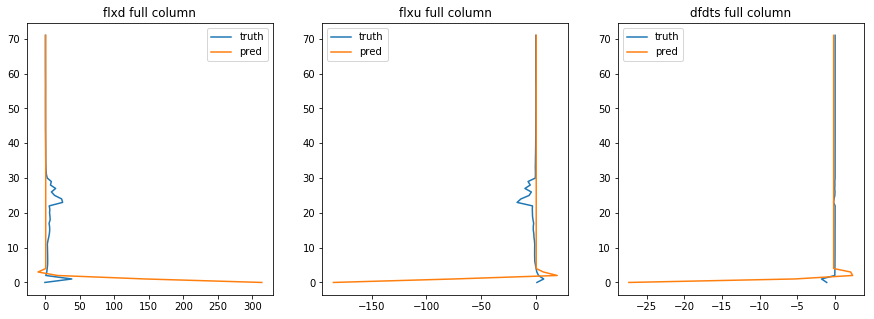

<Figure size 1080x576 with 0 Axes>

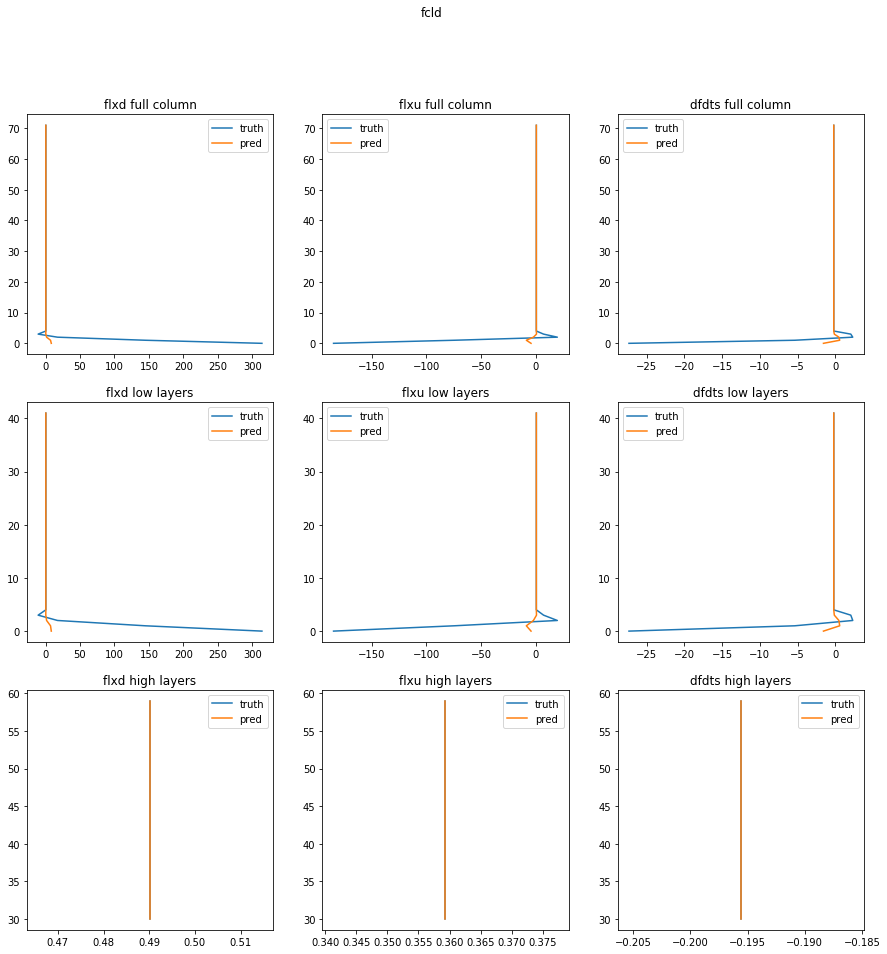

<Figure size 1080x576 with 0 Axes>

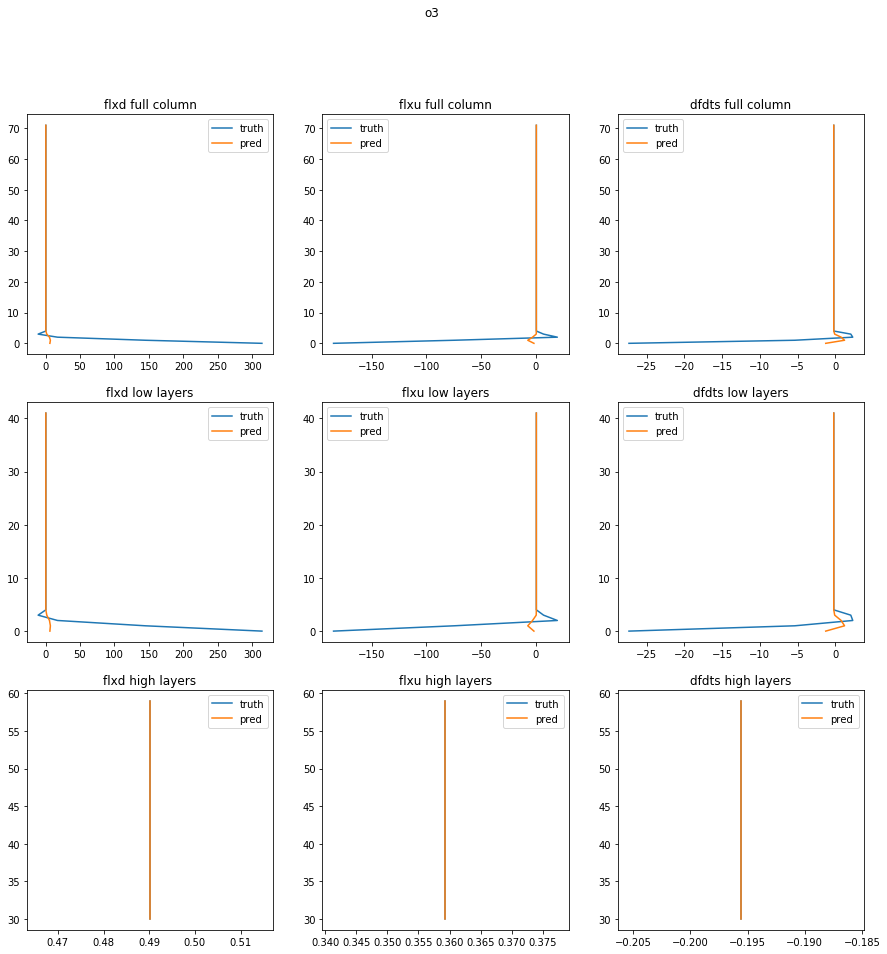

<Figure size 1080x576 with 0 Axes>

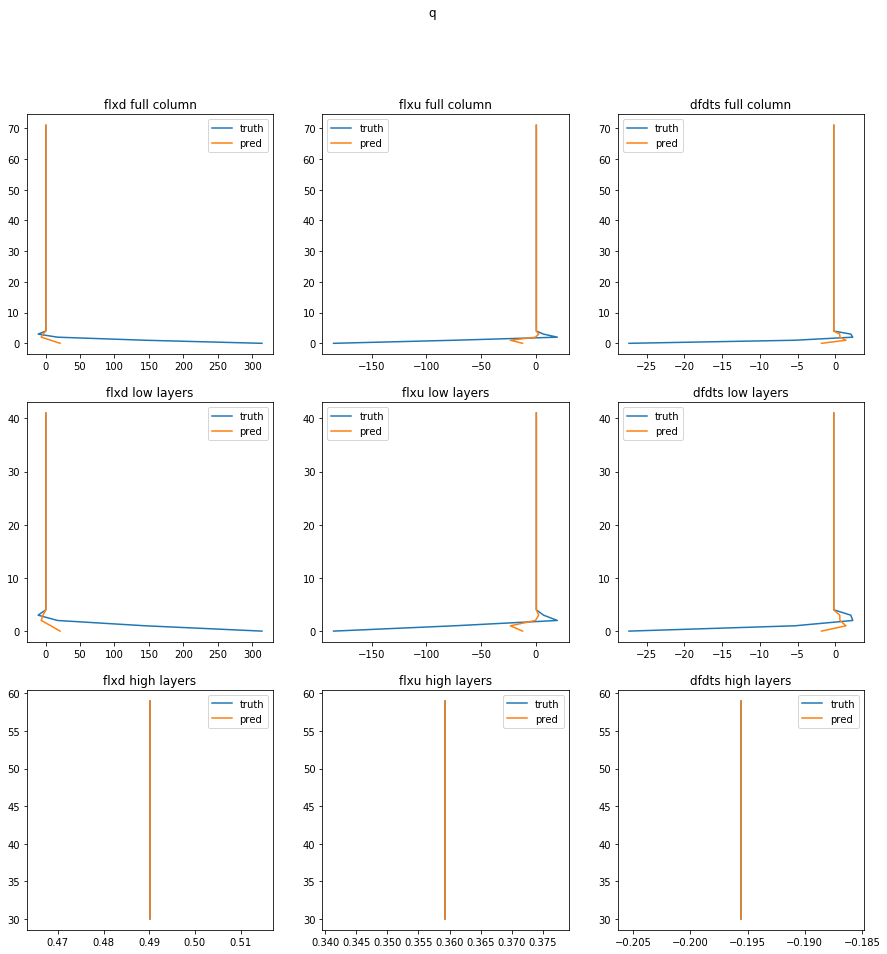

<Figure size 1080x576 with 0 Axes>

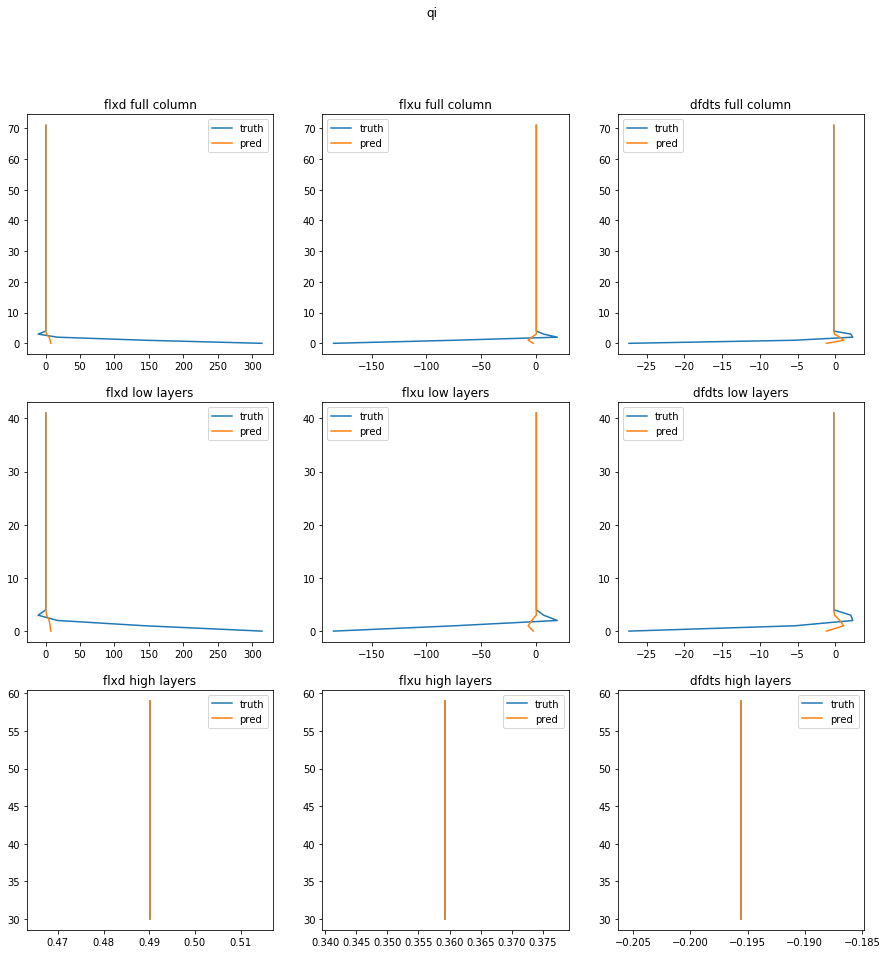

<Figure size 1080x576 with 0 Axes>

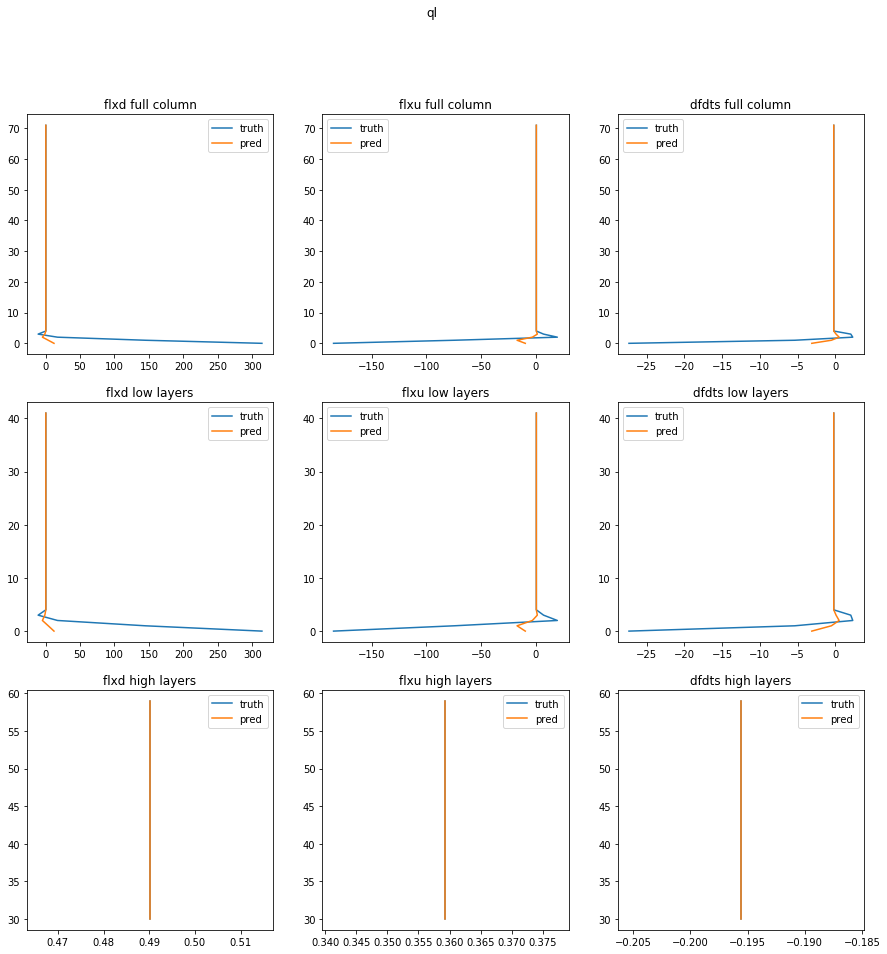

<Figure size 1080x576 with 0 Axes>

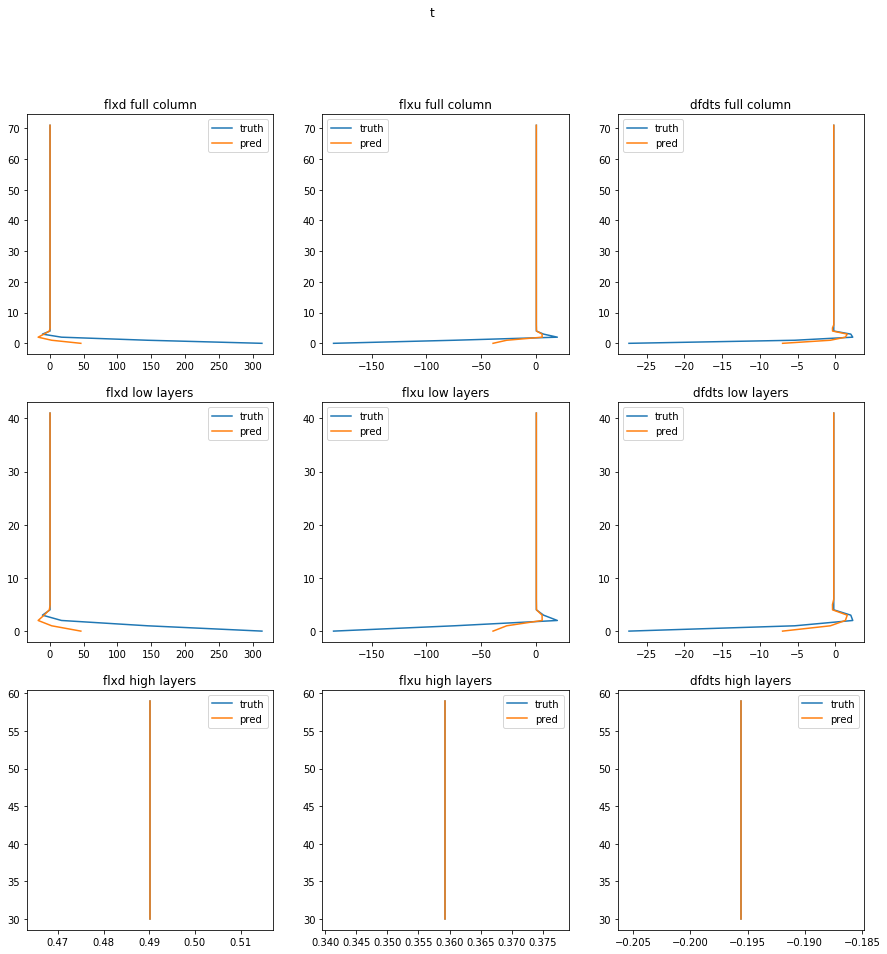

<Figure size 1080x576 with 0 Axes>

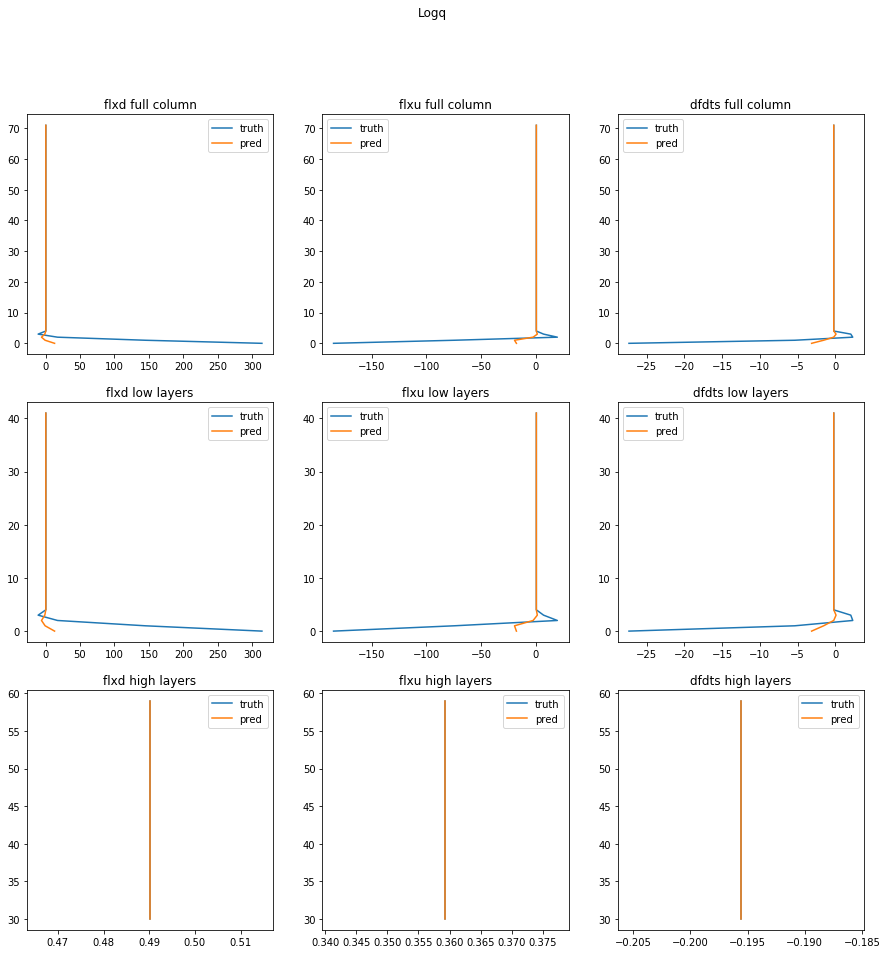

<Figure size 1080x576 with 0 Axes>

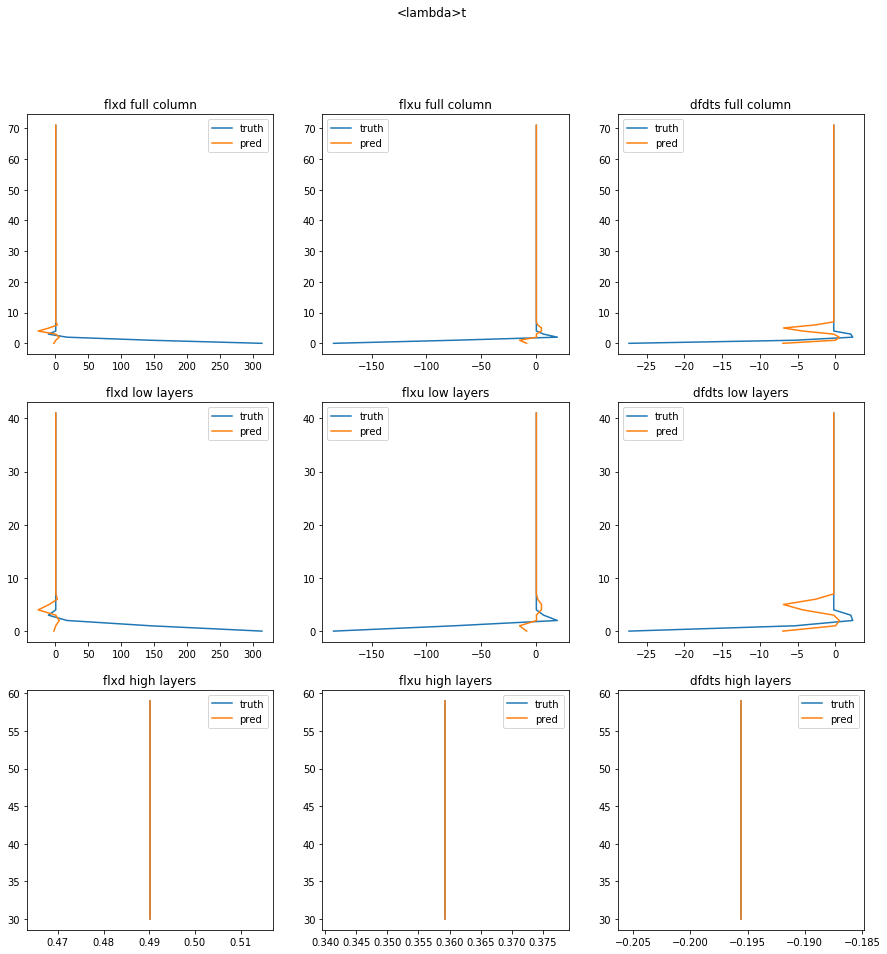

<Figure size 1080x576 with 0 Axes>

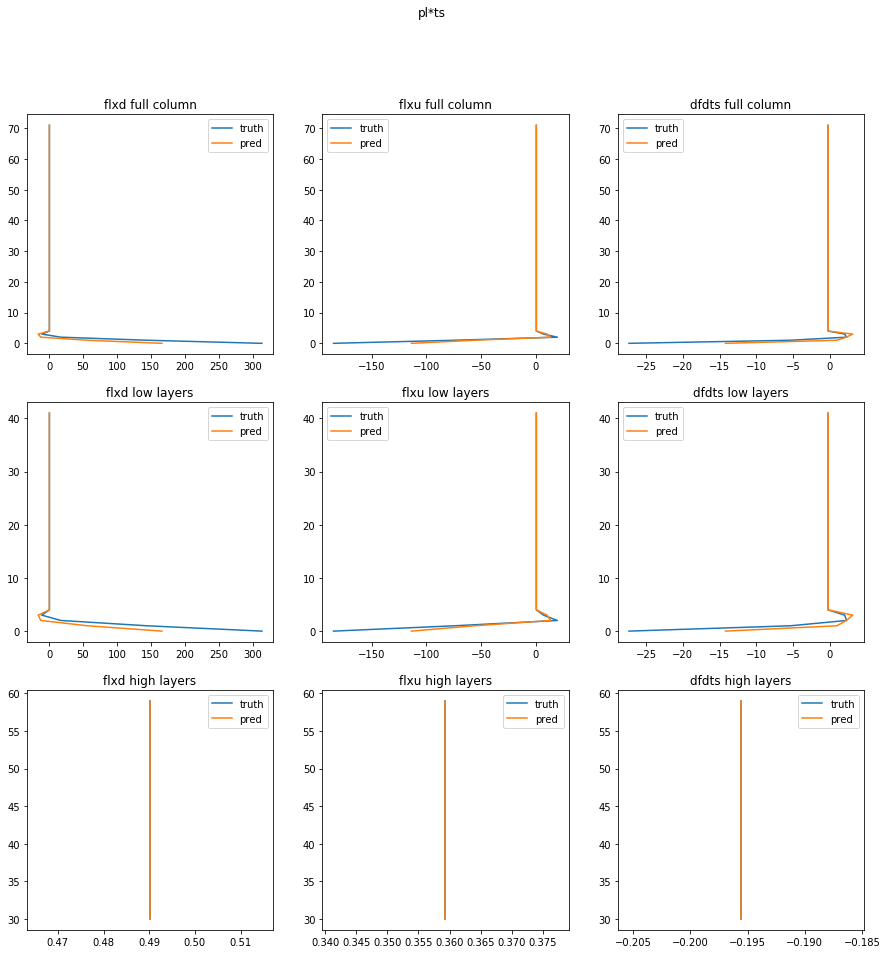

<Figure size 1080x576 with 0 Axes>

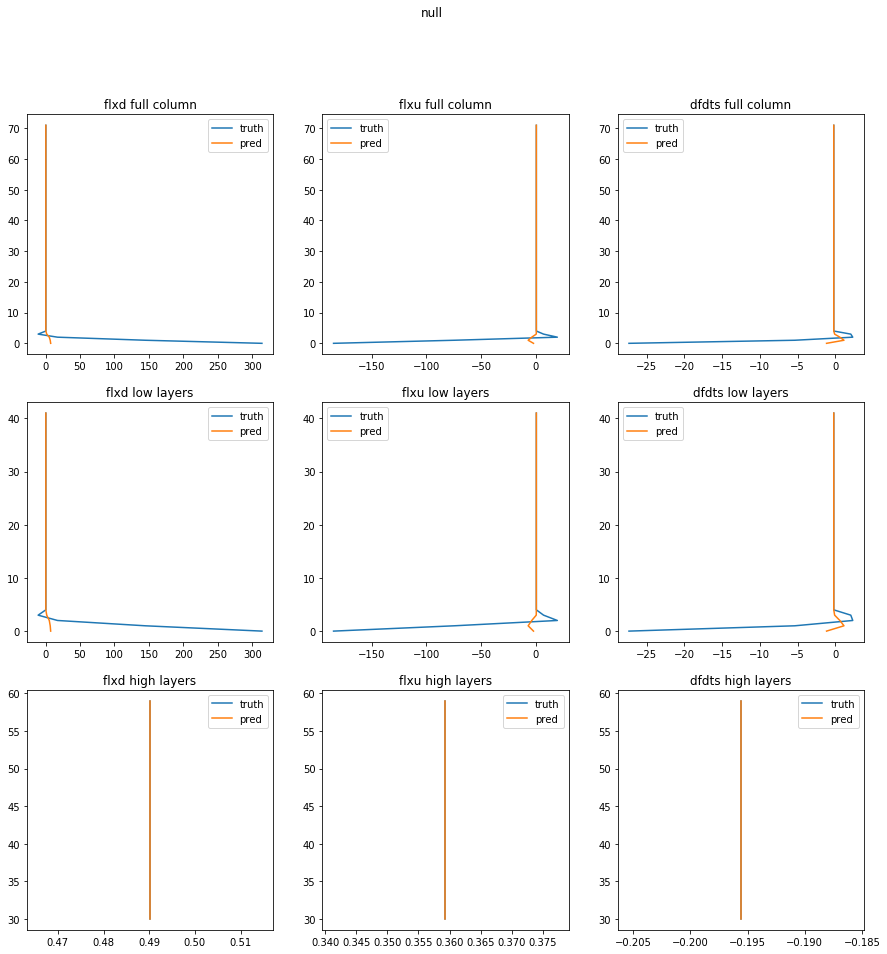

<Figure size 1080x576 with 0 Axes>

In [69]:
from utils import Plot_triple_diff_separated
x,y = validation_generator[500]
y1 = M.predict(x)
y_pred = [M.predict(xi) for xi in X]

F = F_and_plots(shape=(1,3), figsize=(15,5))
Plot_triple_diff_separated(F,y, y1, header_y)
for i,y0 in enumerate(y_pred):
    F = F_and_plots(shape=(3,3), figsize=(15,15))
    if i==len(header_x):
        F.f.suptitle('null')
    else:
        F.f.suptitle(header_x[i])
    Plot_triple_diff_separated(F,y1, y0, header_y, sep=30)

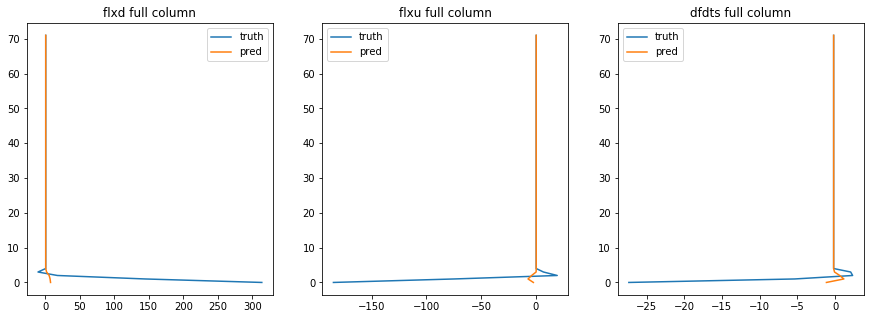

<Figure size 1080x576 with 0 Axes>

In [70]:
F = F_and_plots(shape=(1,3), figsize=(15,5))
Plot_triple_diff_separated(F,y1, y0, header_y);

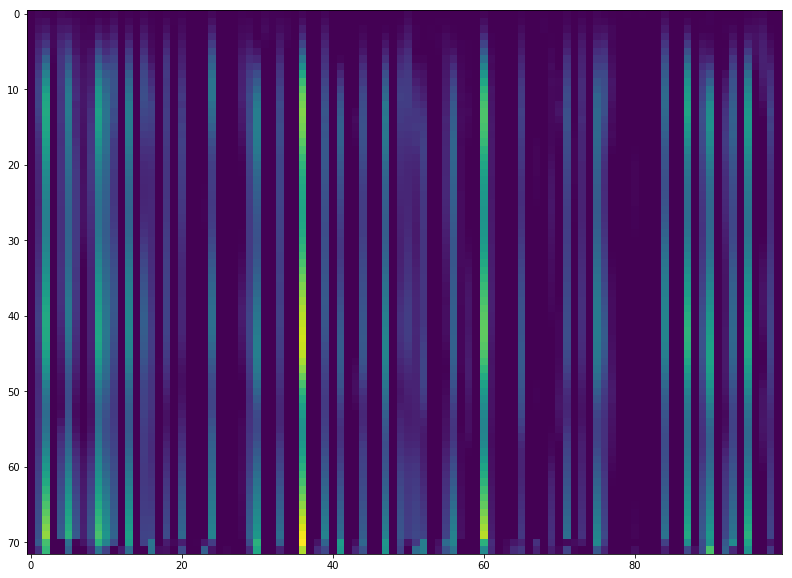

In [71]:
img = First_model(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.mean(img, axis=0))

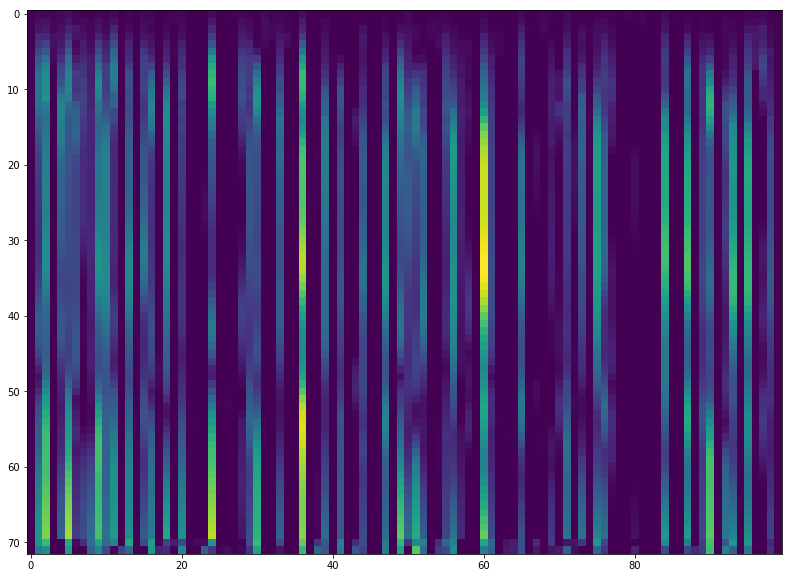

In [82]:
img = First_model(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.std(img, axis=0))

In [85]:
np.max(img)

56.920013

In [85]:
set0=False
x,y = validation_generator[validation_generator.batch_per_file*3+1]

if set0 :
    W = M_unet.get_layer('dense_1').get_weights()
M_unet.get_layer('dense_1').set_weights([W[0]*0, W[1]*0])
y0 = M.predict(x)
M_unet.get_layer('dense_1').set_weights([W[0], W[1]])
y1 = M.predict(x)

## TRAINING ON THE POLE :

In [109]:
train_generator.List_of_dir

['Data2/20190401_0400z', 'Data2/20190401_0400z_antartica']

In [120]:
print(train_generator.idx_folder)
print(train_generator.idx_file)
train_generator.idx_folder = [1]
train_generator.idx_file = [5*i+4 for i in range(5)]
train_generator.max_b = train_generator.batch_per_file*5

[1]
[4, 9, 14, 19, 24]


In [121]:
len(train_generator)

9720

In [124]:
K.set_value(Adam.iterations, len(train_generator))

In [125]:
history = M.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=1,
                               verbose=1)

Epoch 1/1
9720/9720 [==============================] - 588s 60ms/step - loss: 16146.8004 - flxd_loss: 48.7103 - flxu_loss: 14.4843 - dfdts_loss: 15939.7536 - val_loss: 88.7931 - val_flxd_loss: 37.0277 - val_flxu_loss: 15.2483 - val_dfdts_loss: 26.1284


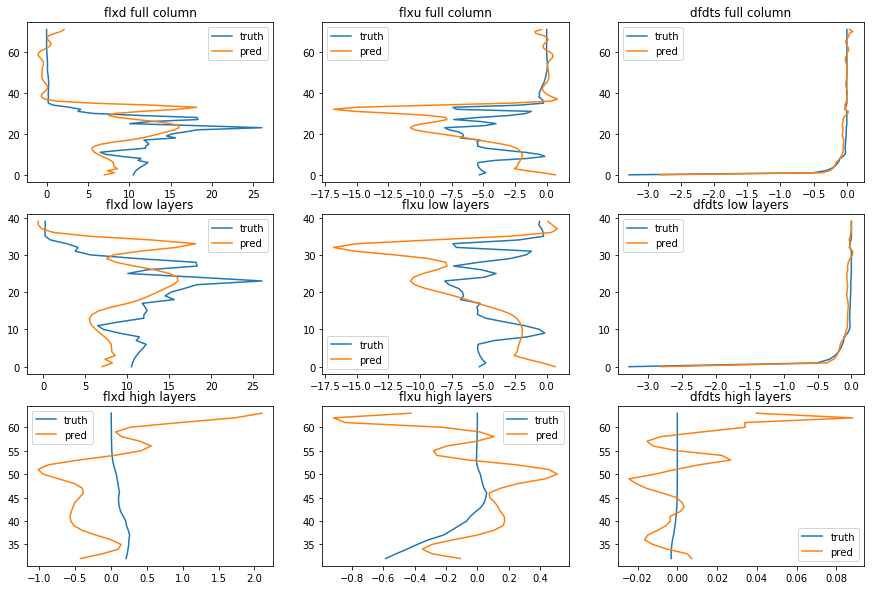

<Figure size 1080x576 with 0 Axes>

In [126]:
from utils import Plot_triple_diff_separated, F_and_plots
x,y = validation_generator[validation_generator.batch_per_file*3+1]
#x*=0
y0 = M.predict(x)
Plot_triple_diff_separated(F_and_plots(shape=(3,3)), y, y0, header_y, 32)

In [43]:
np.max(l[0])

47052

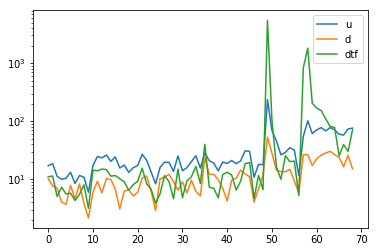

In [32]:
flxu_loss_h = [10.182575995048868, 7.658432195216049, 7.026470168627829, 4.008050361287937, 3.7040922690811473, 7.837056729038066, 4.602975099665638, 8.313896022215792, 3.8213169427565585, 2.15045567893197, 5.931576324588478, 9.224523976015947, 5.811866038130144, 10.196603531700102, 9.89281523276749, 6.727811334555041, 3.070992175443673, 6.24595861866641, 6.557454427083333, 5.142278726208848, 5.903511706693672, 10.507620603459362, 11.317640014146091, 6.258006405928498, 2.881825639387217, 10.15504838605967, 10.904882611561215, 12.105907801247428, 9.050905832047325, 6.422087995113169, 9.01927605774177, 5.792040412808642, 9.61083682966821, 6.199771331661522, 5.143458739229681, 23.149225180041153, 12.082431118184155, 12.157802252121913, 9.795231320730453, 6.940095626768262, 4.202838411056455, 9.643042293595679, 10.42674073270319, 14.273290814686215, 12.320910292888374, 11.046465084876543, 4.022486306021734, 6.867738072273663, 11.724536032343106, 53.07089522247942, 27.917673369984566, 14.326857076260287, 13.470870908886317, 13.480149257330247, 14.78540641878858, 9.252386148083847, 5.802669572241513, 26.317933384773664, 26.5937901877572, 17.141716097608025, 22.57586041988169, 26.00151708783436, 28.361191486625515, 30.276435506687243, 26.537004886831276, 23.820975597993826, 16.39551283596965, 25.777267393261315, 15.083226835776749]
flxd_loss_h = [17.026447563014404, 18.53932974858539, 11.17751736111111, 9.971129115226338, 10.393971635480968, 13.162299262152779, 8.413520969971708, 11.582643108603396, 10.813160083912036, 5.950265138728138, 17.1680089377572, 24.60099987139918, 23.31715374228395, 26.065098138503085, 20.325842335390945, 24.175481851208847, 15.610228989840534, 17.493324813528808, 13.116081331983025, 15.766004774305555, 17.258879484953702, 26.854267136059672, 21.214564445087447, 13.315414617091049, 8.335853105709877, 15.922541112075617, 19.591668274176953, 19.472808963477366, 13.632301110789609, 25.196439766589506, 14.029151194380145, 15.829223130465534, 20.09644659850823, 25.385933079346707, 15.590655542695472, 28.262289416152264, 20.83152689364712, 18.92109535751029, 13.914633166152264, 19.735196839634774, 18.68356159979424, 21.05126551247428, 18.486892762988685, 20.67670355902778, 30.803142280735596, 30.21318198623971, 10.782075858410494, 17.995736078960906, 17.81735869984568, 234.23709169238683, 68.84750353652264, 45.695404931841566, 26.306749131944443, 28.975487477494855, 34.947450488683124, 31.621706613297324, 11.608687789351851, 54.70798369984568, 101.66120113168725, 61.203032568158434, 70.86280703446502, 77.49949363425925, 67.93733121141975, 77.50051440329219, 70.57152617026749, 59.764359085648145, 57.66683947402263, 73.24396379886831, 76.04018775720165]
dfdts_loss_h = [10.998784320344651, 11.374769925090021, 5.023108965084877, 7.2669039753729425, 5.56689654063786, 5.73045970775463, 4.308012032214506, 5.478708526234568, 8.00853587962963, 3.1496373557259516, 14.30347583912037, 13.978491512345679, 14.954811881108538, 14.636160140174898, 11.320879147376543, 11.542900430812757, 10.191769949202675, 8.99561149691358, 6.45435976884002, 8.046754436728396, 9.178772223829732, 15.432885440779321, 8.319918659979423, 6.727030185024434, 3.8488965446566357, 5.6275197723765435, 11.545875329539609, 9.100441261574074, 4.617855119116513, 14.926563906571502, 4.7921926239390435, 9.351351514274691, 10.991118505658436, 16.66398815264918, 8.41502298739712, 39.99355388374486, 7.283361866640947, 6.959469139821245, 4.771930459104938, 12.019961259002057, 13.177666055812757, 11.80002270608282, 6.483045789930555, 9.258630320859053, 18.441243489583332, 19.45037213863169, 4.68150549366641, 11.622251157407407, 6.592103306648663, 5495.3215020576135, 101.99473540380659, 16.26199705021862, 9.96261835294496, 25.359535751028808, 20.084914721579217, 20.471743987911523, 5.1939928345228905, 829.227109053498, 1812.5558127572017, 203.87149562757202, 168.5669045781893, 152.3521412037037, 110.11967110339506, 81.08824427726337, 77.86976755401234, 25.306071968235596, 39.458574459876544, 30.236135223765434, 70.97834683641975]
loss_h  = [38.20778677983539, 37.57253890174897, 23.227121109825102, 21.246065618569958, 19.66498681841564, 26.729775511188272, 17.32450810185185, 25.37526523919753, 22.643018180941358, 11.250356666345164, 37.40305909207819, 47.804032439557616, 44.08381558641975, 50.89774225180041, 41.53954877186214, 42.44617251800412, 28.872958461934157, 32.73490547839506, 26.12785534014918, 28.95507008744856, 32.34115186149691, 52.79479327417695, 40.85204877186214, 26.300475823045268, 15.066574033886317, 31.7051183127572, 42.04243827160494, 40.67915702160494, 27.30103242348251, 46.54509066358025, 27.840615354938272, 30.97263213734568, 40.698419013631685, 48.24976691100823, 29.149108635545268, 91.40514885545268, 40.19732992541152, 38.03834715792181, 28.481788917824073, 38.69523614326132, 36.06409947273662, 42.494357638888886, 35.396629050925924, 44.20859455375514, 61.56528099279836, 60.70999710648148, 19.486064895190328, 36.4857092335391, 36.13399000128601, 5782.648148148148, 198.76019161522635, 76.28420781893004, 49.740290637860085, 67.81508809156378, 69.81776459619341, 61.34581163194444, 22.605324074074073, 910.2536008230453, 1940.8092849794239, 282.21611368312756, 262.0057388117284, 255.85323431069958, 206.4180652006173, 188.86521026234567, 174.97829861111111, 108.89133230452676, 113.52093782150206, 129.25737847222223, 162.1019000771605]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
ax.plot(flxu_loss_h)
ax.plot(dfdts_loss_h)
#ax.plot(loss)
ax.set_yscale('log')
ax.legend(['u','d', 'dtf']);